In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import sys
sys.path.append('../Utilities')
sys.path.append('../ControllersObject')
sys.path.append('../')

import LMPC
import SysModel
from trackInitialization import Map
import utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [20]:
trackMap = Map('3110_big') 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 1000

In [45]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    # NOTE:
    # vx: 0.5 to 2.5/3
    # vy: -1, 1
    # wz: -1, 1
    # espi: -1, 1
    x = np.random.uniform(size=[n]) * np.array([2, 2, 2, 2, trackMap.TrackLength, 2*0.8]) + np.array([0.5, -1, -1, -1, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


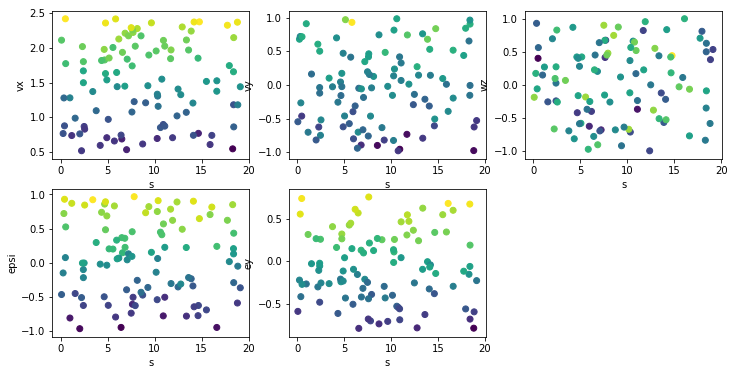

In [46]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])

for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[::10,4], zs[::10,ind], c=ys[::10,ind])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [49]:
best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 5, z_cutoff=n)

In [50]:
best_clustering.fit_clusters(verbose=True)

assigning datapoints to clusters
updating models
centroid movement 3.5417877591
assigning datapoints to clusters
updating models
centroid movement 0.989084699095
assigning datapoints to clusters
updating models
centroid movement 0.484209368907
assigning datapoints to clusters
updating models
centroid movement 0.429575725248
assigning datapoints to clusters
updating models
centroid movement 0.333739515934
assigning datapoints to clusters
updating models
centroid movement 0.229402885826
assigning datapoints to clusters
updating models
centroid movement 0.181858300761
assigning datapoints to clusters
updating models
centroid movement 0.169719818875
assigning datapoints to clusters
updating models
centroid movement 0.127447961114
assigning datapoints to clusters
updating models
centroid movement 0.149439445899
assigning datapoints to clusters
updating models
centroid movement 0.100220796299
assigning datapoints to clusters
updating models
centroid movement 0.1172253726
assigning datapoints

In [8]:
nc_list = [1,4,6,10]
best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n, affine=True)


===================== Fitting model with Nc= 1 ====================
assigning datapoints to clusters
updating models
centroid movement 5.79829317103
assigning datapoints to clusters
updating models
centroid movement 0.0
done
(375, 6) (125, 6)
avg train error: 0.0273206755361
avg test error: 0.0440332055205
===================== Fitting model with Nc= 4 ====================
assigning datapoints to clusters
updating models
centroid movement 3.19765898394
assigning datapoints to clusters
updating models
centroid movement 1.8367619181
assigning datapoints to clusters
updating models
centroid movement 1.49253270836
assigning datapoints to clusters
updating models
centroid movement 0.937857428704
assigning datapoints to clusters
updating models
centroid movement 0.80586186362
assigning datapoints to clusters
updating models
centroid movement 0.720770946207
assigning datapoints to clusters
updating models
centroid movement 0.53913542019
assigning datapoints to clusters
updating models
centroi

In [33]:
best_clustering.Nc

10

In [54]:
pwac.print_PWA_models(pwac.get_PWA_models(best_clustering.thetas, n, d))

[[ 0.98  0.04  0.    0.   -0.    0.02   nan -0.02  0.1    nan  0.02]
 [ 0.    0.25 -0.03  0.02  0.   -0.01   nan  0.18 -0.     nan -0.02]
 [-0.03  0.19  0.18 -0.1   0.03 -0.02   nan  4.16  0.03   nan -0.19]
 [ 0.02  0.02  0.06  0.99 -0.01 -0.02   nan  0.26  0.     nan  0.07]
 [ 0.09  0.   -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [-0.    0.05  0.    0.13  0.    1.     nan  0.01  0.     nan -0.  ]]
[[ 1.   -0.02 -0.   -0.01 -0.   -0.01   nan  0.03  0.09   nan  0.01]
 [ 0.01  0.28 -0.04  0.   -0.    0.01   nan  0.23 -0.     nan  0.03]
 [-0.05  0.23  0.27  0.01  0.02  0.02   nan  4.11 -0.     nan -0.25]
 [ 0.03  0.01  0.05  1.   -0.03 -0.02   nan  0.24 -0.     nan  0.44]
 [ 0.09 -0.   -0.   -0.01  1.   -0.03   nan -0.01 -0.     nan  0.05]
 [ 0.01  0.05 -0.    0.13 -0.01  1.01   nan  0.03  0.     nan  0.08]]
[[ 0.99  0.01  0.    0.01 -0.01 -0.04   nan  0.02  0.09   nan -0.01]
 [ 0.02  0.29 -0.05 -0.   -0.01 -0.     nan  0.23 -0.01   nan  0.  ]
 [-0.06  0.22  0.26  0.01 -0.   

In [51]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 64000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 4035, constraints m = 8000
Cones:	linear vars: 8000
Setup time: 3.58e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.70e+00  4.19e+00  9.38e-01 -5.06e+00  1.00e+01  0.00e+00  1.72e-02 
   100| 8.28e-02  2.01e-01  2.25e-02  5.01e-01  5.47e-01  2.98e-16  3.53e-01 
   200| 5.37e-02  9.09e-02  2.64e-02  1.14e-01  1.47e-01  2.73e-16  7.52e-01 
   300| 2.23e-02  4.00e-02  1.43e-02  5.96e-02  7.58e-02 

In [52]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

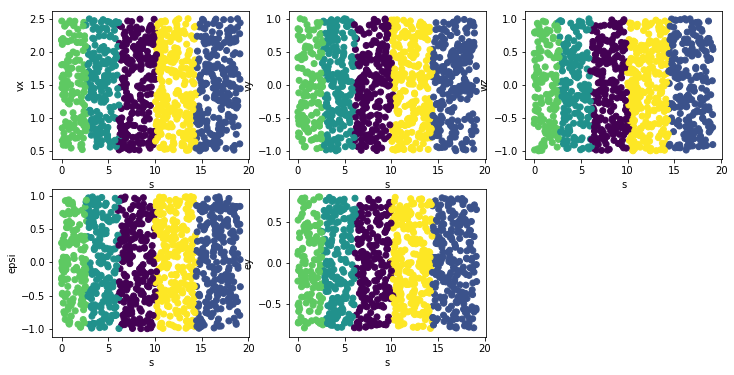

In [53]:
data = np.load('pwa_model_5.npz')
# looks like everything is in the same region here....

labels = []
for z,y in zip(zs,ys):
    dot_pdt = [w.T.dot(np.hstack([z[0:n], [1]])) for w in data['region_fns']]
    labels.append(np.argmax(dot_pdt))

plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']

In [22]:
data.keys()

['labels', 'region_fns', 'ys', 'zs', 'thetas']

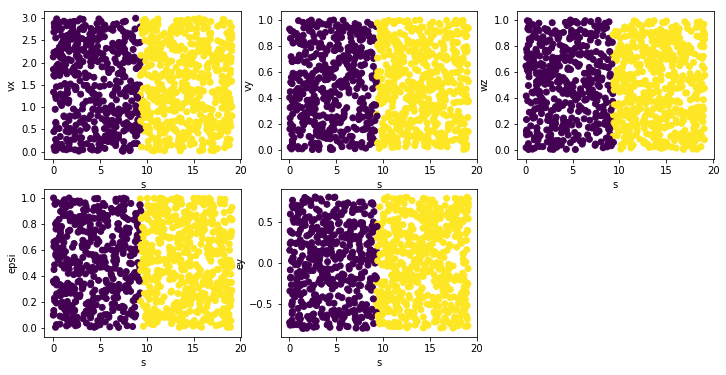

In [17]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

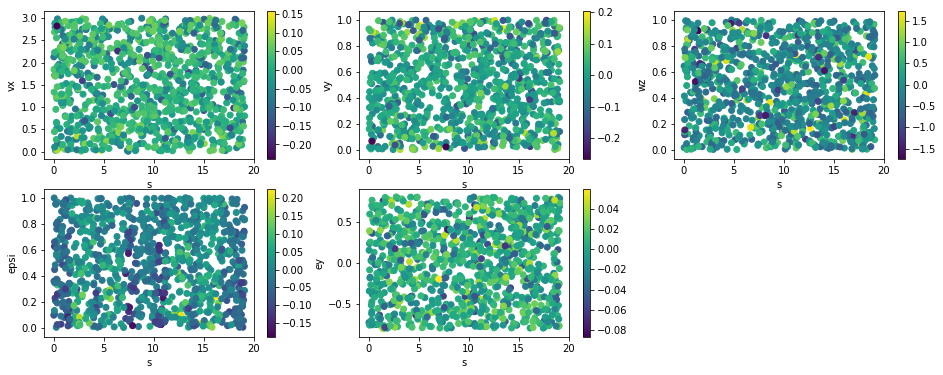

In [18]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [9]:
best_clustering.Nc

15

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]


In [ ]:
# 10 regions (fit from sim)
[[ 0.99 -0.04 -0.03  0.02  0.    0.03   nan  0.21  0.11   nan -0.  ]
 [ 0.08  0.26 -0.03 -0.05  0.   -0.02   nan  0.24  0.02   nan -0.08]
 [-0.11  0.73 -0.05 -0.28  0.    0.31   nan  2.93  0.13   nan  0.04]
 [ 0.02  0.03  0.02  1.   -0.   -0.03   nan  0.16  0.02   nan  0.  ]
 [ 0.08  0.02 -0.   -0.07  1.   -0.03   nan  0.01 -0.     nan  0.02]
 [ 0.06  0.02 -0.    0.09  0.    0.99   nan  0.03  0.02   nan -0.05]]

In [ ]:
# 2 regions (fit from sim)
[[ 0.98  0.03 -0.01  0.01  0.    0.     nan  0.07  0.1    nan -0.01]
 [ 0.06  0.22 -0.02 -0.03  0.    0.     nan  0.23  0.02   nan -0.05]
 [ 0.05  0.28  0.01 -0.02  0.    0.04   nan  2.73  0.04   nan -0.07]
 [ 0.03  0.01  0.02  1.01  0.   -0.02   nan  0.18  0.     nan  0.  ]
 [ 0.08 -0.    0.   -0.06  1.   -0.03   nan -0.01 -0.     nan  0.02]
 [ 0.05  0.03 -0.    0.08  0.    1.     nan  0.03  0.01   nan -0.04]]
[[ 0.98  0.02 -0.01 -0.   -0.   -0.     nan  0.15  0.1    nan  0.  ]
 [ 0.06  0.24 -0.04 -0.03 -0.    0.01   nan  0.18  0.01   nan -0.05]
 [ 0.07  0.1   0.07  0.07  0.01  0.08   nan  3.32  0.01   nan -0.04]
 [ 0.03  0.01  0.03  1.    0.   -0.02   nan  0.2   0.     nan  0.  ]
 [ 0.09 -0.01  0.01 -0.06  1.   -0.04   nan -0.01  0.     nan  0.02]
 [ 0.05  0.04 -0.    0.08 -0.    1.     nan  0.03  0.     nan -0.04]]


In [ ]:
# 2 (1) regions (fit from trajectory)
[[ 0.95  0.53 -0.05 -0.01 -0.    0.03   nan  0.01  0.09   nan  0.01]
 [-0.01 -0.    0.01 -0.    0.   -0.01   nan  0.25 -0.     nan  0.01]
 [-0.19 -0.94  0.15 -0.02  0.   -0.08   nan  2.41 -0.03   nan  0.12]
 [ 0.02  0.01  0.02  1.09 -0.    0.02   nan  0.18  0.01   nan  0.  ]
 [ 0.09 -0.02  0.   -0.01  1.   -0.02   nan -0.    0.     nan  0.  ]
 [ 0.01 -0.03  0.01  0.07  0.    1.     nan  0.02  0.     nan -0.  ]]
[[ 0.83  0.39 -0.05  0.02 -0.   -0.05   nan  0.04  0.09   nan  0.12]
 [-0.01 -0.12  0.02  0.   -0.   -0.     nan  0.25 -0.     nan  0.01]
 [-0.21 -2.13  0.27  0.03 -0.   -0.04   nan  2.43 -0.     nan  0.14]
 [ 0.01 -0.22  0.05  1.1  -0.    0.01   nan  0.18 -0.     nan  0.01]
 [ 0.08  0.03 -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [ 0.    0.01  0.    0.07 -0.    1.     nan  0.02  0.     nan -0.  ]]
